I ran the following notebook in a docker container with the following commands:

```
docker run -it -v `pwd`:/space/ -p 8888:8888 -p 6006:6006 --name dl -w /space/ --rm utensil/dl:models_notop jupyter notebook --ip=0.0.0.0` to start.
```

In [1]:
%%bash
pip2 install -U pip
pip2 install -U Pillow
pip2 install -U captcha
pip2 install -U tensorflow
pip2 install -U theano
pip2 install -U keras
pip2 install -U tflearn
pip2 install -U pandas
pip2 install -U scikit-learn
pip2 install -U h5py
pip2 install -U pydot-ng

Requirement already up-to-date: pip in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: Pillow in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: captcha in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: Pillow in /usr/local/lib/python2.7/dist-packages (from captcha)
Requirement already up-to-date: tensorflow in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: numpy>=1.11.0 in /usr/local/lib/python2.7/dist-packages (from tensorflow)
Requirement already up-to-date: wheel in /usr/local/lib/python2.7/dist-packages (from tensorflow)
Requirement already up-to-date: mock>=2.0.0 in /usr/local/lib/python2.7/dist-packages (from tensorflow)
Requirement already up-to-date: six>=1.10.0 in /usr/local/lib/python2.7/dist-packages (from tensorflow)
Requirement already up-to-date: protobuf>=3.1.0 in /usr/local/lib/python2.7/dist-packages (from tensorflow)
Requirement already up-to-date: funcsigs>=1; python_versio

Retrying (Retry(total=4, connect=None, read=None, redirect=None)) after connection broken by 'NewConnectionError('<pip._vendor.requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x7fd885c09cd0>: Failed to establish a new connection: [Errno 101] Network is unreachable',)': /simple/pip/
Retrying (Retry(total=3, connect=None, read=None, redirect=None)) after connection broken by 'NewConnectionError('<pip._vendor.requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x7fd885c09e50>: Failed to establish a new connection: [Errno 101] Network is unreachable',)': /simple/pip/
/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:318: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to 

In [2]:
import os
from io import BytesIO
import glob
import math
import random
import sys
import PIL
import numpy as np
from numpy import argmax, array
import tflearn
from tflearn.layers.core import input_data, fully_connected, dropout, flatten
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_utils import to_categorical
from captcha.image import ImageCaptcha,WheezyCaptcha

In [49]:
from sklearn.cross_validation import train_test_split
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.utils import np_utils
from keras.layers import merge, Convolution2D, MaxPooling2D, Input, Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import backend as K
IS_TH = K.backend() == 'theano'
IS_TH = True

In [43]:
FONTS = glob.glob('/usr/share/fonts/truetype/dejavu/*.ttf')
SAMPLE_SIZE = 20
TEST_SAMPLE_RATE = 0.3
NB_BATCH = 10
SHOW_SAMPLE_SIZE = 5
INVALID_DIGIT = -1
DIGIT_COUNT = 4
DIGIT_FORMAT_STR = "%%0%dd" % DIGIT_COUNT
CLASS_COUNT = 10
RGB_COLOR_COUNT = 3
# standard width for the whole captcha image
IMAGE_STD_WIDTH = 200
# standard height for the whole captcha image
IMAGE_STD_HEIGHT = 200
CONV1_NB_FILTERS = IMAGE_STD_HEIGHT / 2 + 2
CONV2_NB_FILTERS = IMAGE_STD_HEIGHT + 2 * 2
OUT_PUT_NAME_FORMAT = 'out_%02d'
NB_EPOCH = 10
BATCH_SIZE = 128
OPTIMIZER = 'adadelta' # 'adam' # 'adadelta'

In [50]:
def generate_image_sets_for_single_digit(nb_sample=SAMPLE_SIZE, single_digit_index=0, fonts=None):
    captcha = ImageCaptcha(fonts=fonts) if fonts else ImageCaptcha()

    # print DIGIT_FORMAT_STR
    labels = []
    images = []
    for i in range(0, nb_sample):
        digits = 0
        last_digit = INVALID_DIGIT
        for j in range(0, DIGIT_COUNT):
            digit = last_digit
            while digit == last_digit:
                digit = random.randint(0, 9)
            last_digit = digit
            digits = digits * 10 + digit
        digits_as_str = DIGIT_FORMAT_STR % digits
        labels.append(digits_as_str)
        images.append(captcha.generate_image(digits_as_str))

    digit_labels = list()

    for digit_index in range(0, DIGIT_COUNT):
        digit_labels.append(np.empty(nb_sample, dtype="int8"))

    shape = (nb_sample, RGB_COLOR_COUNT, IMAGE_STD_HEIGHT, IMAGE_STD_WIDTH) if IS_TH else (nb_sample, IMAGE_STD_HEIGHT, IMAGE_STD_WIDTH, RGB_COLOR_COUNT)
    digit_image_data = np.empty(shape, dtype="float32")

    for index in range(0, nb_sample):
        img = images[index].resize((IMAGE_STD_WIDTH, IMAGE_STD_HEIGHT), PIL.Image.LANCZOS)
        # if index < SHOW_SAMPLE_SIZE:
            # display.display(img)
        img_arr = np.asarray(img, dtype="float32") / 255.0
        if IS_TH:
            digit_image_data[index, :, :, :] = np.rollaxis(img_arr, 2)
        else:
            digit_image_data[index, :, :, :] = img_arr

        for digit_index in range(0, DIGIT_COUNT):
            digit_labels[digit_index][index] = labels[index][digit_index]

    x = digit_image_data
    y = np_utils.to_categorical(digit_labels[single_digit_index], CLASS_COUNT)

    return x, y

In [45]:
import IPython.display as display
import string

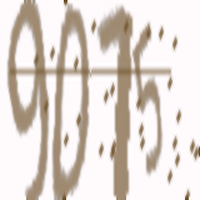

9

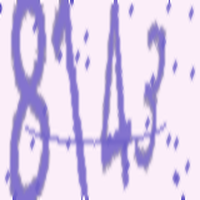

8

In [51]:
SAMPLE_SIZE = 2
x, y = generate_image_sets_for_single_digit(SAMPLE_SIZE)
for i in range(0, SAMPLE_SIZE):
    x_i = np.rollaxis(x[i], 0, 3)
    x_as_img = PIL.Image.fromarray(np.uint8(x_i * 255.0), 'RGB')
    display.display(x_as_img)
    y_as_num = array([np.argmax(j) for j in y])[i]
    display.display(y_as_num)

In [52]:
def generate_image_sets_for_multi_digits(nb_sample=SAMPLE_SIZE, fonts=None):
    captcha = ImageCaptcha(fonts=fonts) if fonts else ImageCaptcha()

    # print DIGIT_FORMAT_STR
    labels = []
    images = []
    for i in range(0, nb_sample):
        digits = 0
        last_digit = INVALID_DIGIT
        for j in range(0, DIGIT_COUNT):
            digit = last_digit
            while digit == last_digit:
                digit = random.randint(0, 9)
            last_digit = digit
            digits = digits * 10 + digit
        digits_as_str = DIGIT_FORMAT_STR % digits
        labels.append(digits_as_str)
        images.append(captcha.generate_image(digits_as_str))

    digit_labels = np.empty((nb_sample, DIGIT_COUNT), dtype="int8")

    shape = (nb_sample, RGB_COLOR_COUNT, IMAGE_STD_HEIGHT, IMAGE_STD_WIDTH) if IS_TH else (nb_sample, IMAGE_STD_HEIGHT, IMAGE_STD_WIDTH, RGB_COLOR_COUNT)
    digit_image_data = np.empty(shape, dtype="float32")

    for index in range(0, nb_sample):
        img = images[index].resize((IMAGE_STD_WIDTH, IMAGE_STD_HEIGHT), PIL.Image.LANCZOS)
        # if index < SHOW_SAMPLE_SIZE:
            # display.display(img)
        img_arr = np.asarray(img, dtype="float32") / 255.0

        if IS_TH:
            digit_image_data[index, :, :, :] = np.rollaxis(img_arr, 2)
        else:
            digit_image_data[index, :, :, :] = img_arr

        for digit_index in range(0, DIGIT_COUNT):
            digit_labels[index][digit_index] = labels[index][digit_index]
    x, y_as_num = digit_image_data, np.rollaxis(digit_labels, 1)
    y = { (OUT_PUT_NAME_FORMAT % i ): np_utils.to_categorical(y_as_num[i], CLASS_COUNT) for i in range(0, DIGIT_COUNT) }

    return x, y

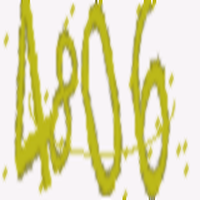

4806


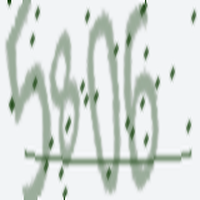

5806


In [55]:
SAMPLE_SIZE = 2
x, y = generate_image_sets_for_multi_digits(SAMPLE_SIZE)
for i in range(0, SAMPLE_SIZE):
    x_i = np.rollaxis(x[i], 0, 3)
    x_as_img = PIL.Image.fromarray(np.uint8(x_i * 255.0), 'RGB')
    display.display(x_as_img)
    # y_as_num = array([np.argmax(j) for j in y])[i]
    # array([ argmax(j) for j in array([r[i]]) ])
    # y_as_num = [[ argmax(j) for j in array([y[k]]) ] for k in range(0, DIGIT_COUNT)]
    y_i = [y['out_%02d' % j][i] for j in range(0, DIGIT_COUNT)]
    y_i_as_num = [ str(argmax(k)) for k in y_i]
    print int(string.join(y_i_as_num, ''))
    # print y_as_num

In [56]:
POOL_SIZE = (2, 2)
def create_cnn_layers():
    shape = (RGB_COLOR_COUNT, IMAGE_STD_HEIGHT, IMAGE_STD_WIDTH) if IS_TH else (IMAGE_STD_HEIGHT, IMAGE_STD_WIDTH, RGB_COLOR_COUNT)
    dim_ordering = 'th' if IS_TH else 'tf'

    input_layer = Input(name='input', shape=shape)
    h = Convolution2D(22, 5, 5, activation='relu', dim_ordering=dim_ordering)(input_layer)
    h = MaxPooling2D(pool_size=POOL_SIZE)(h)
    h = Convolution2D(44, 3, 3, activation='relu', dim_ordering=dim_ordering)(h)
    h = MaxPooling2D(pool_size=POOL_SIZE)(h)
    h = Dropout(0.25)(h)
    last_cnn_layer = Flatten()(h)
    return (input_layer, last_cnn_layer)
def create_multi_digit_model(model_file='', digit_count=DIGIT_COUNT):
    input_layer, last_cnn_layer = create_cnn_layers()

    outputs = []
    loss = {}
    for index in range(0, digit_count):
        h = Dense(256, activation='relu')(last_cnn_layer)
        h = Dropout(0.5)(h)
        out_name = OUT_PUT_NAME_FORMAT % index
        output = Dense(CLASS_COUNT, activation='softmax', name=out_name)(h)
        loss[out_name] = 'categorical_crossentropy'
        outputs.append(output)

    model = Model(input=input_layer, output=outputs)
    model.compile(
        optimizer='adadelta',
        loss=loss
    )
    return model

In [57]:
model = create_multi_digit_model('', DIGIT_COUNT)
model.load_weights('model/model_mul_410.hdf5')

In [58]:
y_predict = model.predict(x) # np.rollaxis(x, 3, 1))

In [59]:
y_predict

[array([[  1.61103178e-16,   1.84247149e-13,   1.05887251e-16,
           2.92940501e-21,   1.00000000e+00,   3.26687241e-17,
           7.44577612e-18,   1.88293894e-18,   3.11937522e-18,
           9.36957472e-17],
        [  1.32526729e-19,   7.49033618e-17,   5.10821090e-20,
           1.62231990e-13,   5.99879755e-19,   1.00000000e+00,
           3.08598280e-13,   8.68895719e-21,   3.12834882e-14,
           4.31429388e-14]], dtype=float32),
 array([[  2.97441347e-12,   9.22141360e-19,   8.94225828e-14,
           5.95711640e-07,   1.30120174e-18,   1.09066411e-09,
           3.79217437e-13,   3.51074146e-17,   9.99999404e-01,
           8.67994739e-12],
        [  4.44823484e-11,   1.41876794e-17,   8.31972834e-17,
           1.01629676e-05,   5.56476188e-16,   3.90891319e-06,
           6.04039885e-09,   6.55008241e-19,   9.99985933e-01,
           8.96010466e-09]], dtype=float32),
 array([[  9.99962449e-01,   2.90041990e-05,   2.55332998e-06,
           1.78491433e-07,   2.7823

In [83]:
def verify(sample_size_per_batch, batch_count, fonts=None):
    for batch_id in range(0, batch_count):
        x, y = generate_image_sets_for_multi_digits(sample_size_per_batch)
        y_predict = model.predict(x)
        for i in range(0, len(x)):
            x_i = np.rollaxis(x[i], 0, 3)
            x_as_img = PIL.Image.fromarray(np.uint8(x_i * 255.0), 'RGB')

            y_i = [y['out_%02d' % j][i] for j in range(0, DIGIT_COUNT)]
            y_i_as_num = [ str(argmax(k)) for k in y_i]
            expected = int(string.join(y_i_as_num, ''))

            y_predict_i = [y_predict[j][i] for j in range(0, DIGIT_COUNT)]
            y_predict_i_as_num = [ str(argmax(k)) for k in y_predict_i]
            predicted = int(string.join(y_predict_i_as_num, ''))
            if expected != predicted:
                display.display(x_as_img)
                print 'predicted: %04d' % predicted
                print 'expected: %04d' % expected

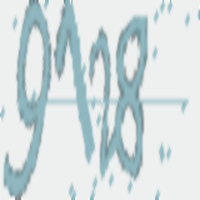

predicted: 9148
expected: 9128


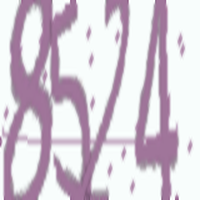

predicted: 8574
expected: 8524


In [84]:
verify(10, 10)

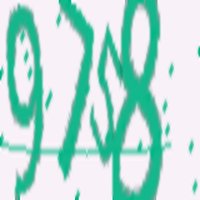

predicted: 9748
expected: 9758


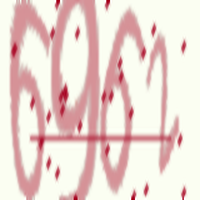

predicted: 6961
expected: 6962


In [86]:
verify(10, 10, fonts=[
            './fonts/megrim/Megrim.ttf',
            './fonts/grundschrift/Grundschrift-Regular.otf',
            './fonts/fantasque-sans-mono/FantasqueSansMono-Regular.ttf'])

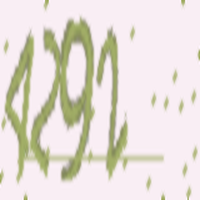

predicted: 4290
expected: 4292


In [87]:
verify(10, 10, fonts=['./fonts/ballpoint/Ballpointprint.ttf'])

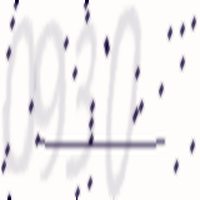

predicted: 0937
expected: 0930


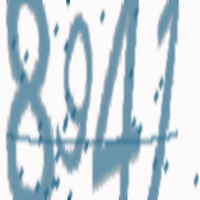

predicted: 8947
expected: 8941


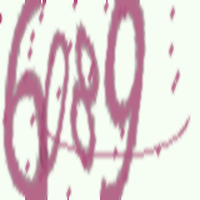

predicted: 6289
expected: 6089


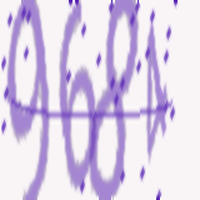

predicted: 9681
expected: 9684


In [88]:
verify(10, 10, fonts=[
            './fonts/megrim/Megrim.ttf',
            './fonts/grundschrift/Grundschrift-Regular.otf',
            './fonts/fantasque-sans-mono/FantasqueSansMono-Regular.ttf',
            './fonts/ballpoint/Ballpointprint.ttf'])